In [1]:
import os
import xmltodict
import dict2xml

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib.widgets import Button

import keras_ocr

from pprint import pprint

%matplotlib widget

# Load dataset

In [2]:
def load_image_names(root_path):
    return list(os.listdir(root_path + '/images'))

def load_image(root_path, file_name):
    image = plt.imread(root_path + '/images/' + file_name)
    return image

def load_points(root_path, file_name):
    with open(root_path + '/annots/' + file_name[:-3] + 'xml') as file:
        file_data = file.read()
        
    dict_data = xmltodict.parse(file_data)
    object_data = dict_data['annotation']['object']
    if type(object_data) is not list:
        object_data = [object_data]

    coords_data = [obj['bndbox'] for obj in object_data]

    return [[[float(c['xmin']), float(c['ymin'])], float(c['xmax']) - float(c['xmin']), float(c['ymax']) - float(c['ymin'])] for c in coords_data]

In [3]:
# subset = 'train'
subset = 'valid'

root_path = f'../dataset/{subset}'

image_names = load_image_names(root_path)
len(image_names)

107

# Add missing coords

In [4]:
def add_point(i, x_min, y_min, x_max, y_max):
    with open(root_path + '/annots/' + image_names[i][:-3] + 'xml') as file:
        file_data = file.read()
        
    dict_data = xmltodict.parse(file_data)
    object_data = dict_data['annotation']['object']
    if type(object_data) is not list:
        object_data = [object_data]
        
    new_object = {'name': 'license-plate', 'pose': 'Unspecified', 'truncated': '0', 'difficult': '0', 'bndbox': {'xmin': str(x_min), 'ymin': str(y_min), 'xmax': str(x_max), 'ymax': str(y_max)}}
    object_data.append(new_object)
    
    dict_data['annotation']['object'] = object_data
    file_data = dict2xml.dict2xml(dict_data)
    
    with open(root_path + '/annots/' + image_names[i][:-3] + 'xml', mode='w') as file:
        file.write(file_data)
        
def _ri(a):
    return round(int(a))

In [5]:
i = 0

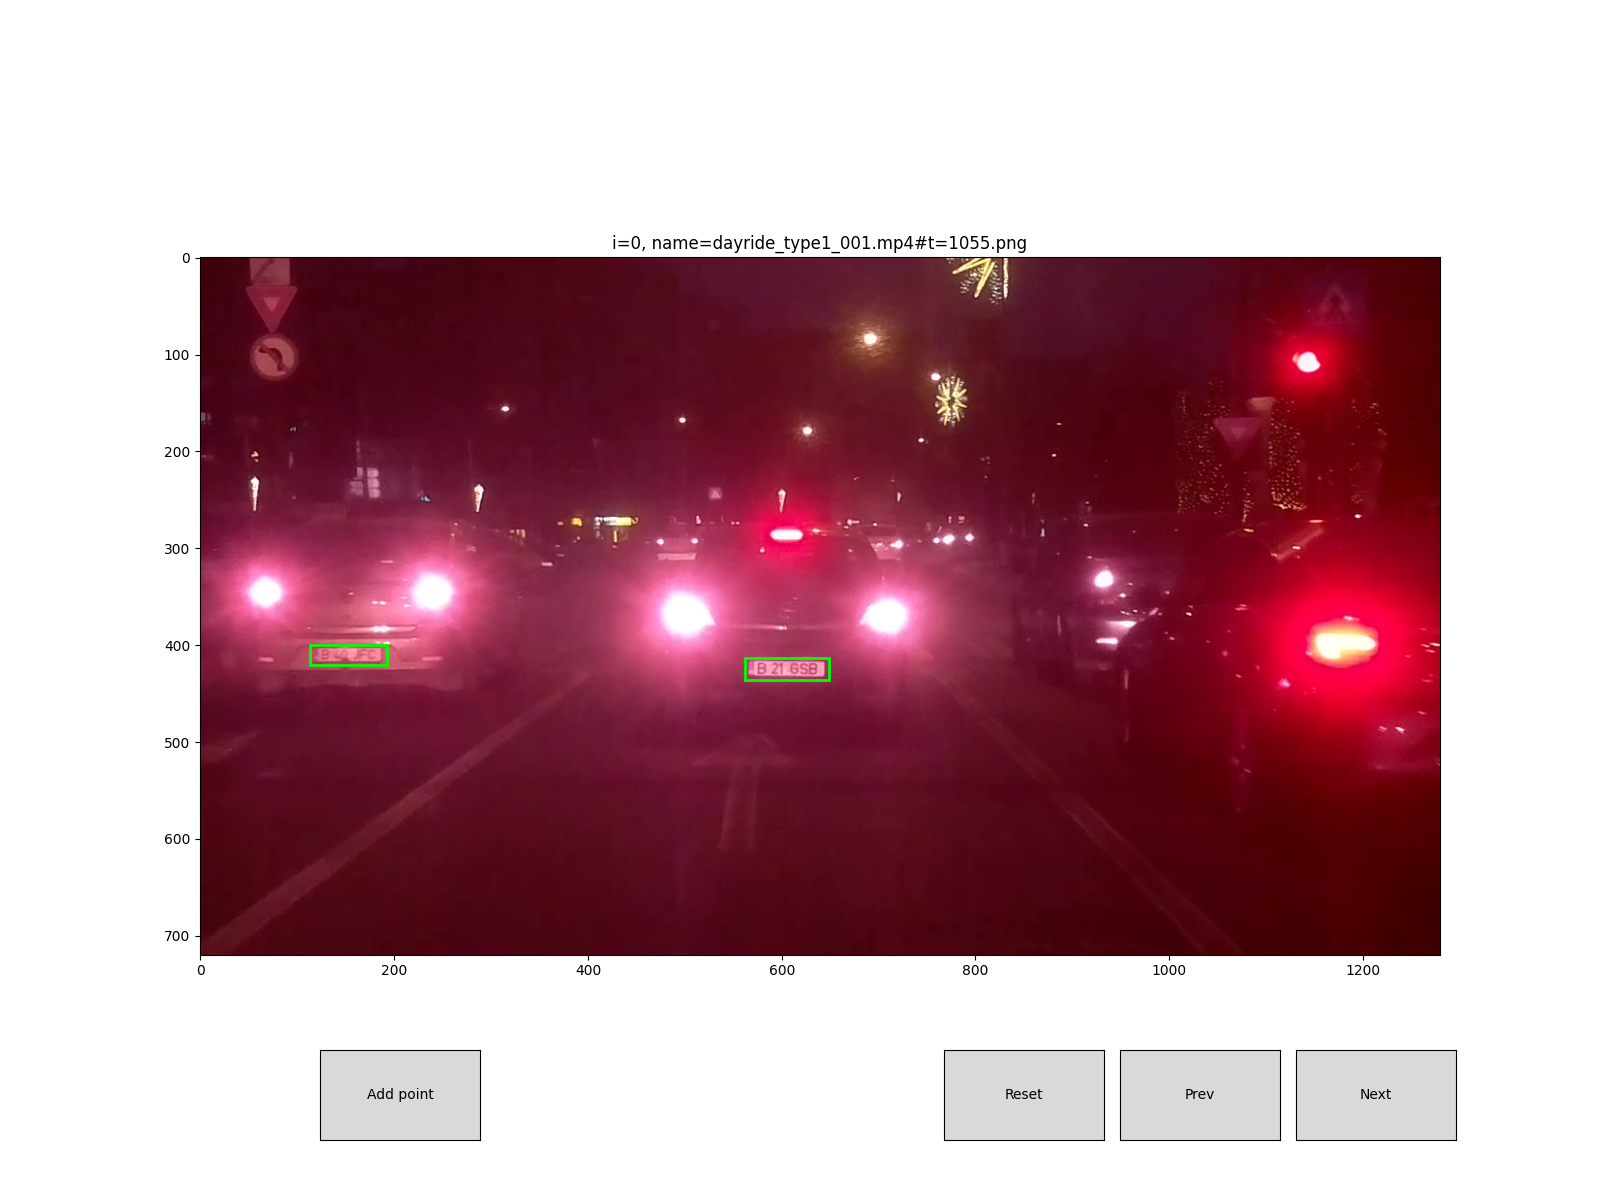

In [6]:
fig, ax = plt.subplots(figsize=(16, 12))

class Callbacks:
    def __init__(self, i):
        self.i = i
        
    def next_cb(self, event):
        self.i += 1
        self.draw()
        
    def prev_cb(self, event):
        self.i -= 1
        self.draw()
        
    def reset_cb(self, event):
        self.draw()
        
    def add_cb(self, event):
        x_min = _ri(ax.get_xlim()[0] - 6)
        x_max = _ri(ax.get_xlim()[1] + 6)
        y_min = _ri(ax.get_ylim()[1] - 3)
        y_max = _ri(ax.get_ylim()[0] + 3)
        ax.set_title(f'Added {x_min}, {y_min}, {x_max}, {y_max}')
        add_point(i=self.i, x_min=x_min, y_min=y_min, x_max=x_max, y_max=y_max)
        
    def draw(self):
        ax.clear()
        ax.set_title(f'i={self.i}, name={image_names[self.i]}')

        image_name = image_names[self.i]
        image = load_image(root_path, image_name)
        points = load_points(root_path, image_name)

        ax.imshow(image)

        for bbox in points:
            rect = patches.Rectangle(*bbox, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

        plt.draw()
        
callbacks = Callbacks(i)
callbacks.draw()

badd = Button(plt.axes([0.2, 0.05, 0.1, 0.075]), 'Add point')
badd.on_clicked(callbacks.add_cb)
breset = Button(plt.axes([0.59, 0.05, 0.1, 0.075]), 'Reset')
breset.on_clicked(callbacks.reset_cb)
bprev = Button(plt.axes([0.7, 0.05, 0.1, 0.075]), 'Prev')
bprev.on_clicked(callbacks.prev_cb)
bnext = Button(plt.axes([0.81, 0.05, 0.1, 0.075]), 'Next')
bnext.on_clicked(callbacks.next_cb)
    
plt.show()

# Check if the annots match the images

In [15]:
set([file[:-3] for file in os.listdir('../dataset/train/annots')]) == set([file[:-3] for file in os.listdir('../dataset/train/images')])

True

In [16]:
set([file[:-3] for file in os.listdir('../dataset/valid/annots')]) == set([file[:-3] for file in os.listdir('../dataset/valid/images')])

True